In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
# EXPECTED_N = [2000,2000,4000,15000]
EXPECTED_N = 10000
#EXPECTED_N = [20000]*4

## Torus model

In [3]:
def simulator(z, center = np.array([0.6, 0.8])):
    r = sum((z[:2]-center)**2)**0.5  # Return radial distance from center
    x = np.array([z[0], r, z[2]])
    return x

def noise(x, z = None, noise = np.array([0.03, 0.005, 0.2])):
    n = np.random.randn(*x.shape)*noise
    return x + n

z0 = np.array([0.57, 0.8, 1.0])
zdim = len(z0)
x0 = simulator(z0)  # Using Asimov data

In [4]:
cache = swyft.MemoryCache(zdim = zdim, xshape = x0.shape)

Creating new cache.


## Inference

In [5]:
intensity = None
pre = None
rn = False

for i in range(4):
    if intensity is None:
        intensity = swyft.get_unit_intensity(
            expected_n=EXPECTED_N, 
            dim=zdim
        )
    else:
        intensity = swyft.get_constrained_intensity(
            expected_n=EXPECTED_N,
            ratio_estimator=re,
            x0=x0,
            threshold=1e-4,
        )
    
    cache.grow(intensity)
    cache.simulate(simulator)
    
    points = swyft.Points(cache, intensity, noise)
    
    statistics = swyft.get_norms(points)
    re = swyft.RatioEstimator(
        points, 
        device=DEVICE, 
        previous_ratio_estimator=pre,
        recycle_net=rn,
        statistics=statistics
    )
    re.train(
        max_epochs=MAX_EPOCHS, 
        batch_size=32, 
        lr_schedule=[1e-3, 3e-4, 1e-4]
    )
    
    pre=re
    rn=True

Simulate:   2%|▏         | 216/10130 [00:00<00:04, 2152.02it/s]

Adding 10130 new samples. Run simulator!


Simulate: 100%|██████████| 10130/10130 [00:03<00:00, 3025.33it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 3
Start training
LR iteration 0
Validation loss: 147.59297585487366
Validation loss: 138.38098740577698
Validation loss: 136.05979537963867
Validation loss: 137.23055958747864
Total epochs: 4
LR iteration 1
Validation loss: 133.48357582092285
Validation loss: 130.82190561294556
Validation loss: 131.75251650810242
Total epochs: 3
LR iteration 2
Validation loss: 130.39817762374878
Validation loss: 131.08727312088013
Total epochs: 2


Simulate:   3%|▎         | 306/9060 [00:00<00:02, 3052.42it/s]

Constrained posterior area: 0.0820792660592144
Adding 9060 new samples. Run simulator!


Simulate: 100%|██████████| 9060/9060 [00:03<00:00, 3003.51it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 3
Start training
LR iteration 0
Validation loss: 169.98242807388306
Validation loss: 170.60896921157837
Total epochs: 2
LR iteration 1
Validation loss: 170.12873220443726
Validation loss: 165.54908895492554
Validation loss: 164.37572622299194
Validation loss: 166.44426918029785
Total epochs: 4
LR iteration 2
Validation loss: 164.27269840240479
Validation loss: 164.63713026046753
Total epochs: 2


Simulate:   5%|▍         | 307/6754 [00:00<00:02, 3061.62it/s]

Constrained posterior area: 0.026357198310615337
Adding 6754 new samples. Run simulator!


Simulate: 100%|██████████| 6754/6754 [00:02<00:00, 2781.16it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 3
Start training
LR iteration 0
Validation loss: 197.88930463790894
Validation loss: 200.33187913894653
Total epochs: 2
LR iteration 1
Validation loss: 199.98935222625732
Validation loss: 197.56783628463745
Validation loss: 195.346999168396
Validation loss: 194.87450218200684
Validation loss: 196.38836812973022
Total epochs: 5
LR iteration 2
Validation loss: 191.48196411132812
Validation loss: 193.4051685333252
Total epochs: 2


Simulate:   6%|▌         | 312/5067 [00:00<00:01, 3113.71it/s]

Constrained posterior area: 0.012938391943644642
Adding 5067 new samples. Run simulator!


Simulate: 100%|██████████| 5067/5067 [00:01<00:00, 3050.90it/s]


No new simulator runs required.
yshape (shape of features between head and legs): 3
Start training
LR iteration 0
Validation loss: 210.8883719444275
Validation loss: 208.07169485092163
Validation loss: 207.79463958740234
Validation loss: 203.88846063613892
Validation loss: 201.24616527557373
Validation loss: 205.5830979347229
Total epochs: 6
LR iteration 1
Validation loss: 203.29783010482788
Validation loss: 203.9867558479309
Total epochs: 2
LR iteration 2
Validation loss: 206.31553983688354
Validation loss: 203.9621777534485
Validation loss: 200.78311777114868
Validation loss: 201.27006149291992
Total epochs: 4


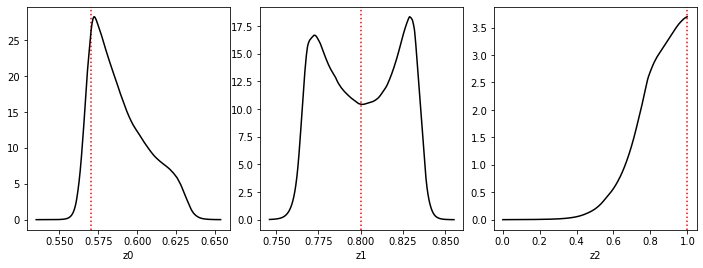

In [6]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (12, 4),max_n_points=10000);

In [7]:
re2 = swyft.RatioEstimator(points, combinations = [[0, 1], [0, 2], [1, 2]], device=DEVICE)

yshape (shape of features between head and legs): 3


In [ ]:
re2.train(max_epochs=MAX_EPOCHS, batch_size=32, lr_schedule=[1e-3, 3e-4, 1e-4], early_stopping_patience=5)

Start training
LR iteration 0
Validation loss: 207.06899404525757
Validation loss: 205.99343061447144
Validation loss: 201.35333681106567
Validation loss: 197.5129108428955
Validation loss: 194.35709476470947
Validation loss: 193.95268630981445
Validation loss: 195.09806060791016
Validation loss: 196.95778226852417
Validation loss: 194.30684089660645
Validation loss: 186.87263679504395
Validation loss: 182.5034260749817
Validation loss: 182.04381132125854
Validation loss: 189.08551740646362
Validation loss: 180.38390588760376
Validation loss: 183.0518193244934


In [ ]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 10, max_n_points=20000)